<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>



- MANSARD Diane
- POTTIER Clément

<font color='red'>**DEADLINE: March 2 (5:00 pm)**</font>

<font color='red'>**PLease send both pdf ipynb files with name : Name1_Name2_Project1**</font>

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

## Preparation of the training data

In [2]:
training_data = pd.read_csv('training_set_N1K_Nsim200.csv')
training_data = training_data.to_numpy()
X_data = training_data[:,:5]
y_data = training_data[:,5:]
X = X_data
target_y = y_data
print(training_data.shape)
print('X shape:', X.shape)
print('Y shape:', target_y.shape)

(1000, 93)
X shape: (1000, 5)
Y shape: (1000, 88)


Split the Data between training (85%) and testing (15%) and normalise inputs between $[-1,1]$ and center/standardise outputs. 

In [3]:
#splitting the data to training and testing set
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T,X),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42)

train_index = X_train[:,0].astype(int)
test_index = X_test[:,0].astype(int)
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [4]:
#Normalising input data x to the interval of [-1, 1]
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x-x_min)/(x_max-x_min)*(norm_max-norm_min)+norm_min
def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm-norm_min)/(norm_max-norm_min)*(x_max-x_min)+x_min

x_max = np.array([np.max(X_train[:,0]),  np.max(X_train[:,1]),  np.max(X_train[:,2]), np.max(X_train[:,3]), np.max(X_train[:,4])])
x_min = np.array([np.min(X_train[:,0]),  np.min(X_train[:,1]),  np.min(X_train[:,2]), np.min(X_train[:,3]), np.min(X_train[:,4])])
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

In [5]:
#Let's check the range for each parameter:
print('x_max:', x_max)
print('x_min:', x_min)

x_max: [ 0.24967108 59.96829955 34.90021402  4.99735909 -0.10207351]
x_min: [ 0.0301418  10.03377322  5.00723643  1.00133122 -0.89979086]


In [6]:
#Standardising output data y to the interval, so it is centred with variance 1
def output_norm_transform(y, mean, std):
    return (y-mean)/std
def output_norm_transform_inv(y_trans, mean, std):
    return y_trans*std+mean

y_mean = np.average(y_train,axis=0)
y_std = np.std(y_train,axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

Check that the values of the dataset have been well preprocessed :

In [7]:
print("Min X_train après normalisation:", x_train_transform.min())
print("Max X_train après normalisation:", x_train_transform.max())
print("Mean y_train_transform:", y_train_transform.mean())
print("Std y_train_transform:", y_train_transform.std())


Min X_train après normalisation: -1.0
Max X_train après normalisation: 1.0
Mean y_train_transform: -1.5417257488484527e-15
Std y_train_transform: 1.0000000000000002


Ok all good

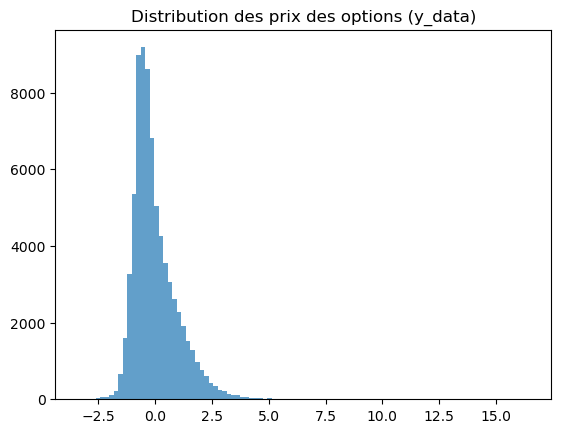

In [8]:
import matplotlib.pyplot as plt

plt.hist(y_train_transform.flatten(), bins=100, alpha=0.7, label='y_train_transform')
plt.title("Distribution des prix des options (y_data)")
plt.show()

## Building of the Neural Network

In [9]:
model_iv = keras.models.Sequential([
    keras.layers.Input(shape=(5,)),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(y_train_transform.shape[1], activation="linear")
])

model_iv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,558 (29.52 KB)

 Trainable params: 7,558 (29.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def error_function(y_true, y_pred):
    return tf.sqrt(tf.math.reduce_mean((y_pred - y_true) ** 2))

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.0001)

model_iv.compile(optimizer=optimizer, loss=error_function)
train_hist = model_iv.fit(x_train_transform, y_train_transform, batch_size=32, epochs=80)

Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9473
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9854 
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9440 
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9996 
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9708 
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0088 
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9273 
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8981 
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8618 
Epoch 10/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8323 
Epoch 11/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7654 
Epoch 12/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7695 
Epoch 13/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7419 
Epoch 14/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7144 
Epoch 15/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7599 
Epoch

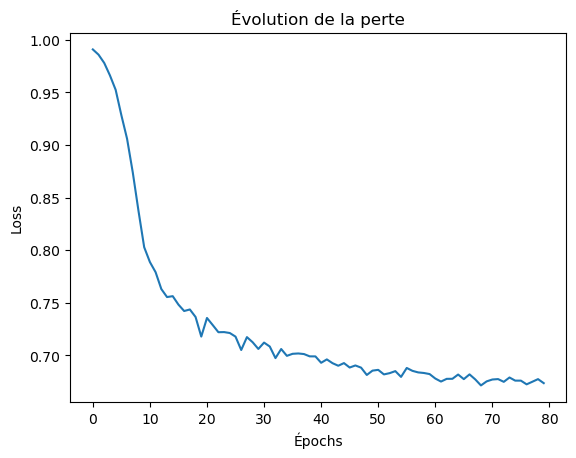

In [11]:
plt.plot(train_hist.history['loss'])
plt.title("Évolution de la perte")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.show()

In [12]:
# Save the model weights
model_iv.save_weights('2FBergomiNNWeights_test.weights.h5')

In [13]:
model_iv.load_weights('2FBergomiNNWeights_test.weights.h5')

In [14]:
test_loss = model_iv.evaluate(x_test_transform, y_test_transform)
print(f"Test Loss: {test_loss}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6536 
Test Loss: 0.6384413242340088


In [15]:
model_iv_2 = keras.models.Sequential([
    keras.layers.Input(shape=(5,)),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(y_train_transform.shape[1], activation="linear")
])

In [16]:
model_iv_2.compile(optimizer=optimizer, loss=error_function)
train_hist_2 = model_iv_2.fit(x_train_transform, y_train_transform, batch_size=200, epochs=100)

Epoch 1/100


NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
plt.plot(train_hist_2.history['loss'])
plt.title("Évolution de la perte")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.show()

NameError: name 'train_hist_2' is not defined

In [ ]:
test_loss = model_iv_2.evaluate(x_test_transform, y_test_transform)

print(f"Test Loss : {test_loss}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8071
Test Loss : 0.8303336501121521


## Final predictions

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018